Reference:
1. [Lin, Y.-X., McCrae, M., and Gulati, C., 2006. **Loss protection in pairs trading through minimum profit bounds: a cointegration approach**](http://downloads.hindawi.com/archive/2006/073803.pdf)

2. [Puspaningrum, H., Lin, Y.-X., and Gulati, C. M. 2010. **Finding the optimal pre-set boundaries for pairs trading strategy based on cointegration technique**](https://ro.uow.edu.au/cgi/viewcontent.cgi?article=1040&context=cssmwp)


# Minimum Profit Optimization

## Introduction

A common pairs trading strategy is to "fade the spread", i.e. to open a trade when the spread is sufficiently far away
from its equilibrium in anticipation of the spread reverting to the mean. Within the context of cointegration, the
spread refers to cointegration error, and in the remainder of this documentation "spread" and "cointegration error" will
be used interchangeably.

In order to define a strategy, we need to quantify the concept of "sufficiently far away from the equilibrium of the
spread", i.e. a pre-set boundary chosen to open a trade, for this boundary can affect the minimum total profit (MTP)
over a specific trading horizon. The higher the pre-set boundary for opening trades, the higher the profit per trade
but the lower the trade numbers. The opposite applies for lowering the boundary values. The number of trades over a
specified trading horizon is determined jointly by the average trade duration and the average inter-trade interval.

In this notebook, we will demonstrate how to optimize the pre-set boundary that would maximize the MTP for cointegration error
following an AR(1) process by numerically estimating the average trade duration, average inter-trade interval, and the
average number of trades based on the mean first-passage time.

## Model Assumptions

Before getting into the nuts and bolts of the optimization process, we need to articulate the assumptions of the cointegration pairs trading strategy.

- The price of two assets ($S_1$ and $S_2$) are cointegrated over the relevant time period, which includes both in-sample and out-of-sample (trading) period.
- The cointegration error follows a stationary AR(1) process.
- The cointegration error is symmetrically distributed so that we can apply the optimal boundary on both sides of the mean.
- Short sales are permitted or possible through a broker and there is no interest charged for the short sales and no cost for trading.
- The cointegration coefficient $\beta > 0$, where a cointegration relationship is defined as:

\begin{equation}
    P_{S_1,t} - \beta P_{S_2,t} = \varepsilon_t
\end{equation}

## Minimum Profit per Trade

Denote a trade opened when the cointegration error $\varepsilon_t$ overshoots the pre-set upper boundary $U$
as a **U-trade**, and similarly a trade opened when $\varepsilon_t$ falls through the pre-set lower
boundary $L$ as an **L-trade**. Without loss of generality, we assume the mean of $\varepsilon_t$ is 0. 

### Minimum Profit per U-trade

The setup of a U-trade is as follows:

- When $\varepsilon_t \geq U$ at $t_o$, we open a trade by selling $N$ of asset $S_1$ and buying $\beta N$ of asset $S_2$.
- When $\varepsilon_t \leq 0$ at $t_c$, we square the trade.

The profit per trade would thus be:

\begin{equation}
    P = N (P_{S_1, t_o} - P_{S_1, t_c}) + \beta N (P_{S_2, t_c} - P_{S_2, t_o})
\end{equation}

Since the two assets are cointegrated during the trade period, we can substitute the cointegration relationship into
the above equation and derive the following:

\begin{align*}
    P & =  N (P_{S_1, t_o} - P_{S_1, t_c}) + \beta N (P_{S_2, t_c} - P_{S_2, t_o}) \\
      & =  N (P_{S_1, t_o} - \beta P_{S_2, t_o}) - N (P_{S_1, t_c} - \beta P_{S_2, t_c}) \\
      & =  N \varepsilon_{t_o} - N \varepsilon_{t_c} \\
      & \geq N U
\end{align*}

### Minimum Profit per L-trade

The setup of a L-trade is as follows:

- When $\varepsilon_t \leq -U$ at $t_o$, we open a trade by buying $N$ of asset $S_1$ and selling $\beta N$ of asset $S_2$.
- When $\varepsilon_t \geq 0$ at $t_c$, we square the trade.

The profit per trade would thus be:

\begin{equation}
    P = N (P_{S_1, t_c} - P_{S_1, t_o}) + \beta N (P_{S_2, t_o} - P_{S_2, t_c})
\end{equation}

Since the two assets are cointegrated during the trade period, we can substitute the cointegration relationship into
the above equation and derive the following:

\begin{align*}
    P & =  N (P_{S_1, t_c} - P_{S_1, t_o}) + \beta N (P_{S_2, t_o} - P_{S_2, t_c}) \\
      & =  N (P_{S_1, t_c} - \beta P_{S_2, t_c}) - N (P_{S_1, t_o} - \beta P_{S_2, t_o}) \\
      & =  N \varepsilon_{t_c} - N \varepsilon_{t_o} \\
      & \geq N U
\end{align*}

**Both U-trades and L-trades would make a minimum profit per trade of $U$ if one unit of the cointegrated pair ($N=1$) were traded.**

## Minimum Total Profit (MTP)

Based on the assumption that the boundary to open trades would be symmetrically applied on both sides of the spread mean, we will focus only on U-trade in this section. We can simply double the results to take L-trades into account.

We have derived the minimum profit per U-trade, and the next question of interest is the MTP over a trading horizon $[0,T]$. We would like to find the optimal boundary $U$ that can allow enough trades within the trading horizon as well as maximize the total profit. Therefore, we can define MTP as a function of the boundary $U$ as follows.

\begin{equation}
    MTP(U) = \Big( \frac{T}{{TD}_U + I_U} - 1 \Big) U
\end{equation}

where ${TD}_U$ is the trade duration and $I_U$ is the inter-trade interval. The derivation from the previous section proved that the minimum profit of one trade is $U$. Therefore, the number of U-trades within the trading horizon is given by:

\begin{equation}
    \frac{T}{{TD}_U + I_U} - 1
\end{equation}

According to the model assumptions, the cointegration error $\varepsilon_t$ follows a stationary AR(1) process. 

\begin{equation}
\varepsilon_t = \phi \varepsilon_{t-1} + a_t \qquad a_t \sim N(0, \sigma_a^2) \text{ i.i.d}
\end{equation}

Without loss of generality, we assume $E(\varepsilon_t) = 0$. Therefore, we can estimate ${TD}_U$ by calculating the average time of $\varepsilon_t$ to pass 0 for the first time given the the initial value of $\varepsilon_{t} = U$.

\begin{equation}
    {TD}_U = E(\mathcal{T}_{0, \infty}(U)) = \lim_{b \to \infty} \frac{1}{\sqrt{2 \pi} \sigma_a} \int_0^b E(\mathcal{T}_{0, b}(s)) \text{ exp} \Big( - \frac{(s- \phi U)^2}{2 \sigma_a^2} \Big) ds + 1
\end{equation}

Similarly, we can estimate $I_U$ by calculating the average time of $\varepsilon_t$ to pass $U$ for the first time given the initial value of $\varepsilon_t = 0$.

\begin{equation}
    I_U = E(\mathcal{T}_{- \infty, U}(0)) = \lim_{-b \to - \infty} \frac{1}{\sqrt{2 \pi} \sigma_a} \int_{-b}^U E(\mathcal{T}_{-b, U}(s)) \text{ exp} \Big( - \frac{s^2}{2 \sigma_a^2} \Big) ds + 1
\end{equation}

### Numerically Estimating the Integral in the Mean First-passage Time of an AR(1) Process

The crux of the optimization algorithm is thus calculating the above two integrals.

Consider a stationary AR(1) process:

\begin{equation}
    Y_t = \phi Y_{t-1} + \xi_t
\end{equation}

where $-1 < \phi < 1$, and
\begin{equation}
    \xi_t \sim N(0, \sigma_{\xi}^2) \text{ i.i.d}
\end{equation}

The mean first-passage time over interval $\lbrack a, b \rbrack$ of $Y_t$, starting at initial state $y_0 \in \lbrack a, b \rbrack$, which is denoted by $E(\mathcal{T}_{a,b}(y_0))$, is given by

\begin{equation}
    E(\mathcal{T}_{a,b}(y_0)) = \frac{1}{\sqrt{2 \pi}\sigma_{\xi}}\int_a^b E(\mathcal{T}_{a,b}(u)) \text{ exp} \Big( - \frac{(u-\phi y_0)^2}{2 \sigma_{\xi}^2} \Big) du + 1
\end{equation}

This integral equation can be solved numerically using the Nystrom method, i.e. by solving the following linear equations:

$$
\begin{pmatrix}
    1 - K(u_0, u_0) & -K(u_0, u_1) & \ldots & -K(u_0, u_n) \\
    -K(u_1, u_0) & 1 - K(u_1, u_1) & \ldots & -K(u_1, u_n) \\
    \vdots & \vdots & \vdots & \vdots \\
    -K(u_n, u_0) & -K(u_n, u_1) & \ldots & 1-K(u_n, u_n)
\end{pmatrix}
\begin{pmatrix}
    E_n(\mathcal{T}_{a,b}(u_0)) \\
    E_n(\mathcal{T}_{a,b}(u_1)) \\
    \vdots \\
    E_n(\mathcal{T}_{a,b}(u_n))
\end{pmatrix}
=   
\begin{pmatrix}
    1 \\
    1 \\
    \vdots \\
    1 \\
\end{pmatrix} 
$$

where $E_n(\mathcal{T}_{a,b}(u_0))$ is a discretized estimate of the integral, and the Gaussian kernel function $K(u_i, u_j)$ is defined as:

\begin{equation}
    K(u_i, u_j) = \frac{h}{2 \sqrt{2 \pi} \sigma_{\xi}} w_j  \text{ exp} \Big( - \frac{(u_j - \phi u_i)^2}{2 \sigma_{\xi}^2} \Big)
\end{equation}

and the weight $w_j$ is defined by the trapezoid integration rule:

\begin{equation}
    w_j = \begin{cases}
    1 & j = 0 \text{ and } j = n \\
    2 & 0 < j < n, j \in \mathbb{N}
    \end{cases}
\end{equation}

The time complexity for solving the above linear equation system is $O(n^3)$ (see [here](https://www.netlib.org/lapack/lug/node71.html) for an introduction of the time complexity of `numpy.linalg.solve`, which is the most time-consuming part of this procedure.

Note that the integrals in the definition of ${TD}_U$ and $I_U$ the integral limit goes to infinity. To approximate the infinity limit, we use the following stylized fact: for a stationary AR(1) process $\{ \varepsilon_t \}$, the probability that the absolute value of the process $\vert \varepsilon_t \vert$ is greater than 5 times the standard deviation of the process $5 \sigma_{\varepsilon}$ is close to 0. Therefore, we will use $5 \sigma_{\varepsilon}$ as an approximation of the infinity limit in the integrals.

## Optimization

Based on the above discussion, we can now give the numerical algorithm to optimize the pre-set boundary that maximizes MTP.

1. Perform Engle-Granger or Johansen test to derive the cointegration coefficient $\beta$.<br>
2. Fit the cointegration error $\varepsilon_t$ to an AR(1) process and retrieve the AR(1) coefficient and the fitted residual.<br>
3. Calculate the standard deviation of cointegration error ($\sigma_{\varepsilon}$) and the fitted residual ($\sigma_a$).<br>
4. Generate a sequence of pre-set upper bounds $U_i$, where $U_i = i \times 0.01, \> i = 0, \ldots, b/0.01$, and $b = 5 \sigma_{\varepsilon}$.<br>
5. For each $U_i$,<br>
  a. Calculate ${TD}_{U_i}$.<br>
  b. Calculate $I_{U_i}$. *Note: this is the main bottleneck of the optimization speed.*<br>
  c. Calculate $MTP(U_i)$.<br>
6. Find $U^{*}$ such that $MTP(U^{*})$ is the maximum.<br>
7. Set a desired minimum profit $K \geq U^{*}$ and calculate the number of assets to trade according to the following equations:<br>
\begin{eqnarray}
N_{S_2} = \Big \lceil \frac{K \beta}{U^{*}} \Big \rceil \\
N_{S_1} = \Big \lceil \frac{N_{S_2}}{\beta} \Big \rceil
\end{eqnarray}

## Want to Test with Simulated Data First?

We also provided the functionality of simulating cointegrated series in case there is trouble finding cointegrated asset pairs from empirical data. 

The simulations are based on the following cointegration model:

\begin{gather*}
    P_{S_1}(t) + \beta P_{S_2}(t) = \varepsilon_t \\
    P_{S_2}(t) - P_{S_2}(t-1) = e_t
\end{gather*}

where $\varepsilon_t$ and $e_t$ are AR(1) processes.

\begin{eqnarray}
\varepsilon_t - \phi_1 \varepsilon_{t-1} = c_1 + \delta_{1,t} \qquad \delta_{1,t} \sim N(0, \sigma_1^2) \\
e_t - \phi_2 e_{t-1} = c_2 + \delta_{2,t} \qquad \delta_{2,t} \sim N(0, \sigma_2^2)
\end{eqnarray}

The module allows simulation of multiple cointegrated series all at once.

## Usage of the Algorithms

### Cointegration Simulation

Firstly, we will showcase the usage of the simulation module.

The following codeblocks will simulate a batch of cointegrated series that are defined by the following parameters.

\begin{eqnarray}
            \phi_1 & = & 0.95 \\
            c_1 & = & 1.5 \\
            \sigma_1 & = & 0.5 \\
            \phi2 & = & 0.9 \\
            c_2 & = & 0.05 \\
            \sigma_2 & = & 1.0 \\
            \beta & = & -0.6 \\
\end{eqnarray}

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
# Import libraries
import os

import numpy as np
import pandas as pd

from arbitragelab.cointegration_approach.coint_sim import CointegrationSimulation
from arbitragelab.cointegration_approach.minimum_profit import MinimumProfit
from arbitragelab.cointegration_approach.trading_simulation import TradingSim

%matplotlib inline

In [5]:
# Initialize the data simulator
# Generate 20 cointegrated series, each of the series have 250 data points.
coint_simulator = CointegrationSimulation(20, 250)

In [6]:
# Set the parameters for e_t
price_params = {
    "ar_coeff": 0.95,
    "white_noise_var": 0.5,
    "constant_trend": 1.5
}

# Set the parameters for epsilon_t
coint_params = {
    "ar_coeff": 0.9,
    "white_noise_var": 1.,
    "constant_trend": 0.05,
    "beta": -0.6
}

# Load the parameters
coint_simulator.load_params(price_params, target='price')
coint_simulator.load_params(coint_params, target='coint')

The simulation can be done either by purely following the recurrence relation given by the AR(1) process, or using the `statsmodels` package. Here we use the `statsmodels` package to simulate the cointegrated series according to the above mentioned parameters.

In [7]:
# Using statsmodels package to simulate the cointegrated series
s1_series, s2_series, coint_errors = coint_simulator.simulate_coint(initial_price=100., use_statsmodel=True)

Plot the simulated cointegrated series and the cointegration error.

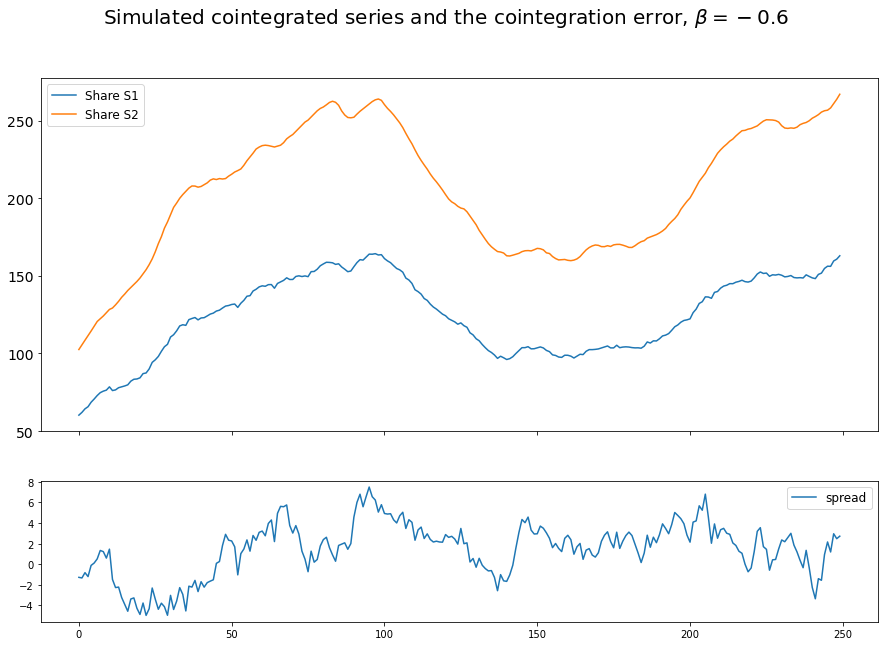

In [9]:
# Plot the simulated cointegrated series and cointegration error.
coint_sim_fig = coint_simulator.plot_coint_series(s1_series[:, 0], s2_series[:, 0], coint_errors[:, 0])

### Minimum Profit Optimization

Selected Ametek Inc. (Ticker: AME) and Dover Corp. (Ticker: DOV) as the cointegrated pairs for trading. Used data from 2016 Jan 4th to 2018 Dec 31st for training. Simulated the trades using data from 2019 Jan 2nd to date. The simulation trading account has \\$1M at the start of the trading simulation, and the minimum profit was set at 0.5\% of the account, i.e. \\$5,000.

In [7]:
data_path = 'AME-DOV.csv'
data = pd.read_csv(data_path, parse_dates=['Date'])
data.set_index('Date', inplace=True)

In [8]:
trade_account = TradingSim(starting_equity=1000000.)
optimizer = MinimumProfit(data)
train_df, trade_df = train_test_split(optimizer.price_df, date_cutoff=pd.Timestamp(2019, 1, 1))

We use Engle-Granger test to calculate cointegration coefficient.

In [9]:
beta_eg, epsilon_t_eg, ar_coeff_eg, ar_resid_eg = optimizer.fit(train_df, use_johansen=False)

C:\Anaconda3\envs\arbitragelab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


These two stocks passed the cointegration test at 95% significance level over the training period. Therefore, we can proceed to the optimization step. The optimization progress was shown as it may take some time to complete.

In [10]:
trade_days = len(trade_df)
optimal_ub, _, _, optimal_mtp, optimal_num_of_trades = optimizer.optimize(ar_coeff_eg, epsilon_t_eg, 
                                                                          ar_resid_eg, len(train_df))

trade_signals, num_of_shares, cond_values = optimizer.trade_signal(trade_df, optimal_ub, 5000, beta_eg, epsilon_t_eg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1858/1858 [17:44<00:00,  1.74it/s]


The optimal upperbound is 2.05, which means if we trade one unit of the spread, the minimum profit should be \\$2.05. In order to achieve the minimum profit of \\$5,000, we need to trade multiple (will insert number afterwards) units.

In [11]:
optimal_ub

2.05

In [12]:
num_of_shares

array([2440., 2316.])

We have acquired the trading signal as well as the amount to trade. Now we can start trading!

In [13]:
trade_account.trade(trade_signals, num_of_shares)

Below are the summary of each trade (open date, open entry price, close date, closing price), the plot of trading signals based on cointegration error, and the equity curve (marked to market everyday) of the trading strategy.

In [14]:
trade_account.summary()

,Trade Date,Trade Type,Leg 1,Leg 1 Shares,Leg 1 Price,Leg 2,Leg 2 Shares,Leg 2 Price
0,2019-01-01,U-trade Open,AME,-2440.0,67.70,DOV,2316.0,70.95
1,2019-01-14,U-trade Close,AME,2440.0,70.21,DOV,-2316.0,78.06
2,2019-01-29,L-trade Open,AME,2440.0,71.77,DOV,-2316.0,86.16
3,2019-05-22,L-trade Close,AME,-2440.0,85.61,DOV,2316.0,93.04
4,2019-06-04,L-trade Open,AME,2440.0,83.67,DOV,-2316.0,94.12
5,2019-07-11,L-trade Close,AME,-2440.0,89.59,DOV,2316.0,97.63
6,2019-07-17,U-trade Open,AME,-2440.0,89.28,DOV,2316.0,95.46
7,2019-07-19,U-trade Close,AME,2440.0,88.71,DOV,-2316.0,98.12
8,2019-08-01,U-trade Open,AME,-2440.0,88.32,DOV,2316.0,94.39
9,2019-09-03,U-trade Close,AME,2440.0,83.38,DOV,-2316.0,92.51


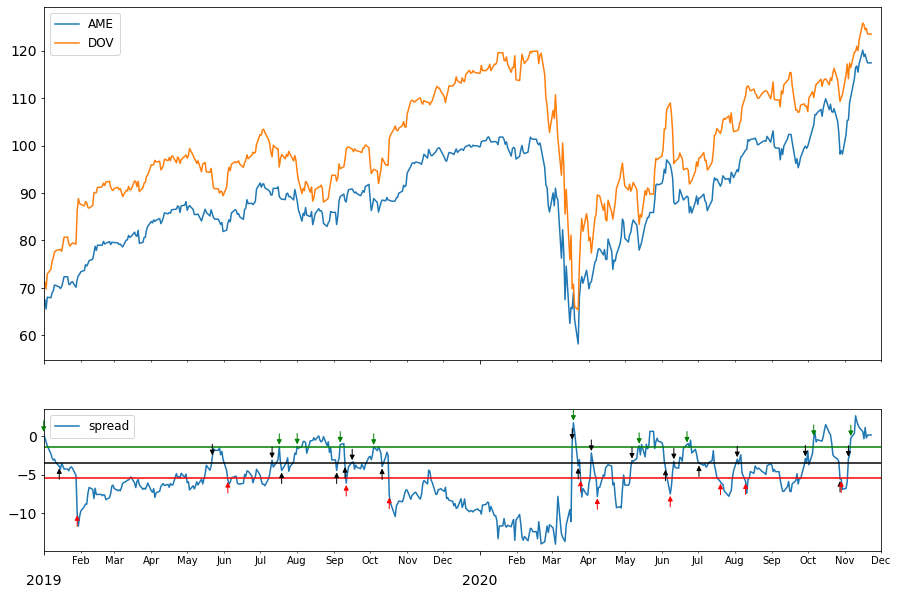

In [27]:
a = trade_account.plot_signals(trade_signals, cond_values, start_date=pd.Timestamp(2019, 1, 1), end_date=pd.Timestamp(2020,12,1))

In [32]:
a.savefig("AME-DOV.png", transparent=False, bbox_inches = 'tight',
    pad_inches = 0.25)

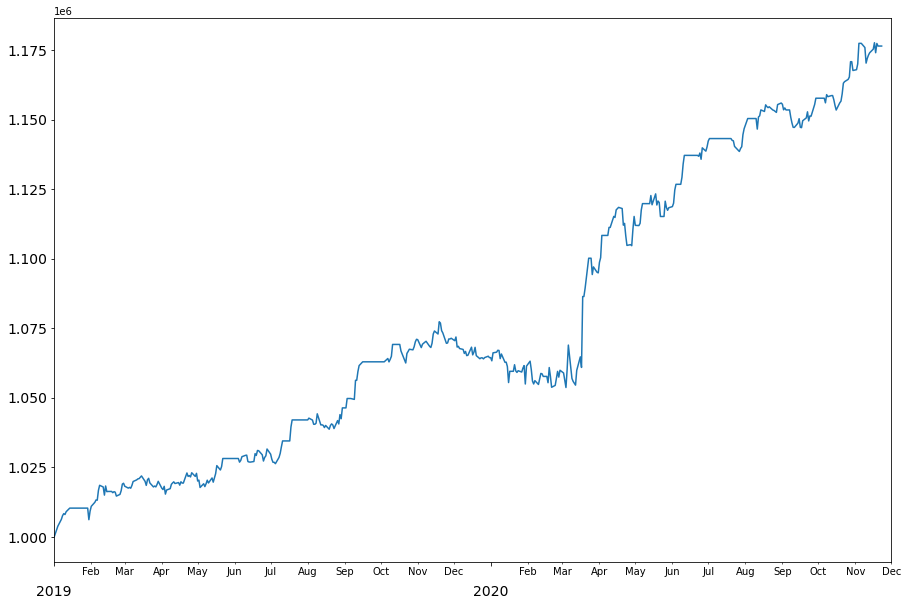

In [16]:
trade_account.plot_equity_curve(trade_signals, start_date=pd.Timestamp(2019, 1, 1), end_date=pd.Timestamp(2020,12,1))